In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style(style="darkgrid")
import os
import csv
import matplotlib.pyplot as plt
import statistics as stat
from scipy import spatial
from scipy.signal import savgol_filter,argrelextrema
import sys
from scipy.optimize import curve_fit
from math import sin, pi

In [172]:
lightname = "light"
lightunit = "ppfd"
timename = "time[s]"
hourname = "time[h]"
odtype = "680" # which OD to use
odname = "OD("+odtype+"nm)"
filetype = '.csv'

cols = [timename,250,500,750,1000,1250,1500,1750,2000,"replicate"]
colnames = []
for i in range(len(cols)):
    if i == 0 or i==len(cols)-1:
        colnames.append(cols[i])
        continue
    col = odname+str(cols[i])
    colnames.append(col)
print(colnames)

['time[s]', 'OD(680nm)250', 'OD(680nm)500', 'OD(680nm)750', 'OD(680nm)1000', 'OD(680nm)1250', 'OD(680nm)1500', 'OD(680nm)1750', 'OD(680nm)2000', 'replicate']


### Cleaning Data

In [173]:
path = os.getcwd()
filenames = os.listdir() # run on all <filetype> files
# filenames = ['A4_A_09302020.csv','A4_B_10012020.csv','A4_C_10022020.csv'] #choose files to run on
replicates = [] #file that contains all replicates of an experiment
runstart = [177,0,237] # row number where the experiment starts (found using excel)
i = 0
for name in (filenames):
    if filetype not in name:
        continue
    filepath = os.path.join(path,name)
    print("Processing:: "+name)
    
    #clean up csv
    A = pd.read_csv(name,skiprows=4,index_col=False)
    cols = [col for col in A.columns
            if odtype not in col and timename not in col]
#     print(cols) # column names to remove
    A = A.drop(columns=cols)
    A = A.drop(index = list(range(0,runstart[i]-1)))
#     print(A.head())
    repname = [i] * len(A)
    A["replicate"] = repname # numbering each replicate for later analysis
#     print(A.columns,'\n',colnames)
    A.columns = colnames
    
    #removing duplicate times in each
    len0 = len(A)
    A = A.drop_duplicates(subset=[timename])
    len1 = len(A)
    diff = len0 - len1
    if diff != 0:
        print(name+":: Dropped",diff,"rows with duplicate \""+timename+"\" values")
    
    # changing from seconds to hours and resetting experiment start time to 0
    s_to_h = 300 / 3600 # 300 seconds between readings / seconds in hour
    t_series = np.arange(0,len(A),1)*s_to_h
    A[timename] = t_series
    
    # changing data format for plotting
    A = pd.wide_to_long(A, odname, i=timename, j=lightname)
#     print(A)
    replicates.append(A)
    i+=1
    
replen = len(replicates)
df = pd.concat(replicates)
df.reset_index(inplace=True)

# adding ppfd because seaborn will ROUND if we just have an integer
df[lightname] = df[lightname].apply(lambda x: str(x) +" "+ lightunit)
df = df.rename(columns={timename:hourname})
df

Processing:: A4_A_09302020.csv
Processing:: A4_B_10012020.csv
Processing:: A4_C_10022020.csv


,time[h],light,replicate,OD(680nm)
0,0.000000,250 ppfd,0,0.104
1,0.083333,250 ppfd,0,0.107
2,0.166667,250 ppfd,0,0.108
3,0.250000,250 ppfd,0,0.110
4,0.333333,250 ppfd,0,0.114
...,...,...,...,...
6803,20.916667,2000 ppfd,2,2.775
6804,21.000000,2000 ppfd,2,2.775
6805,21.083333,2000 ppfd,2,2.696
6806,21.166667,2000 ppfd,2,2.775


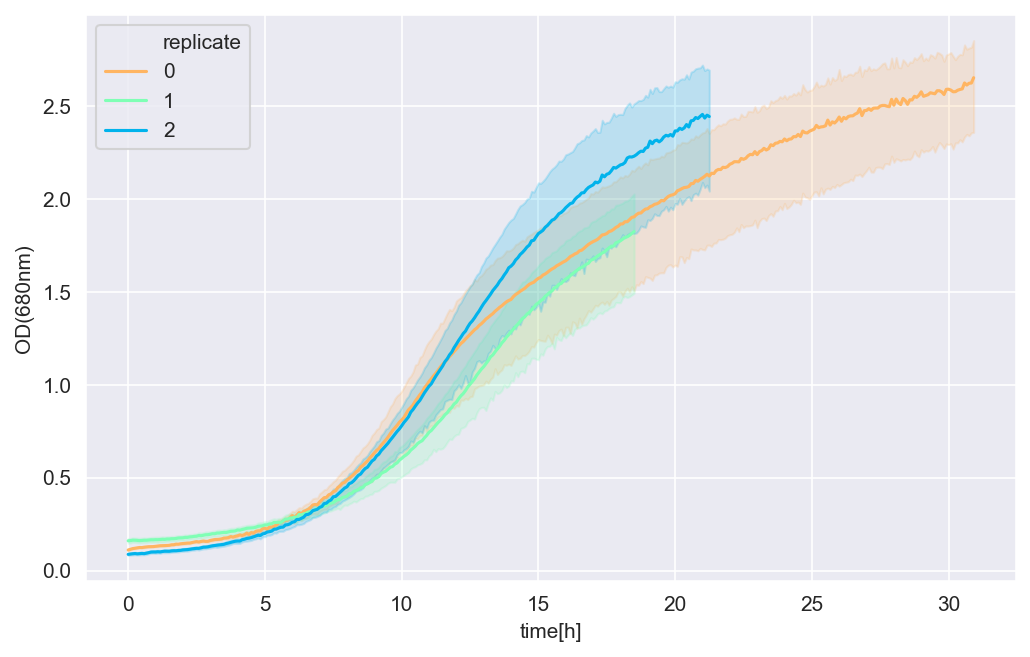

In [174]:
plt.figure(figsize=(8,5), dpi=150)
palette = sns.color_palette("rainbow_r", replen)
sns.lineplot(x=hourname, y=odname,hue="replicate",palette=palette,data=df)

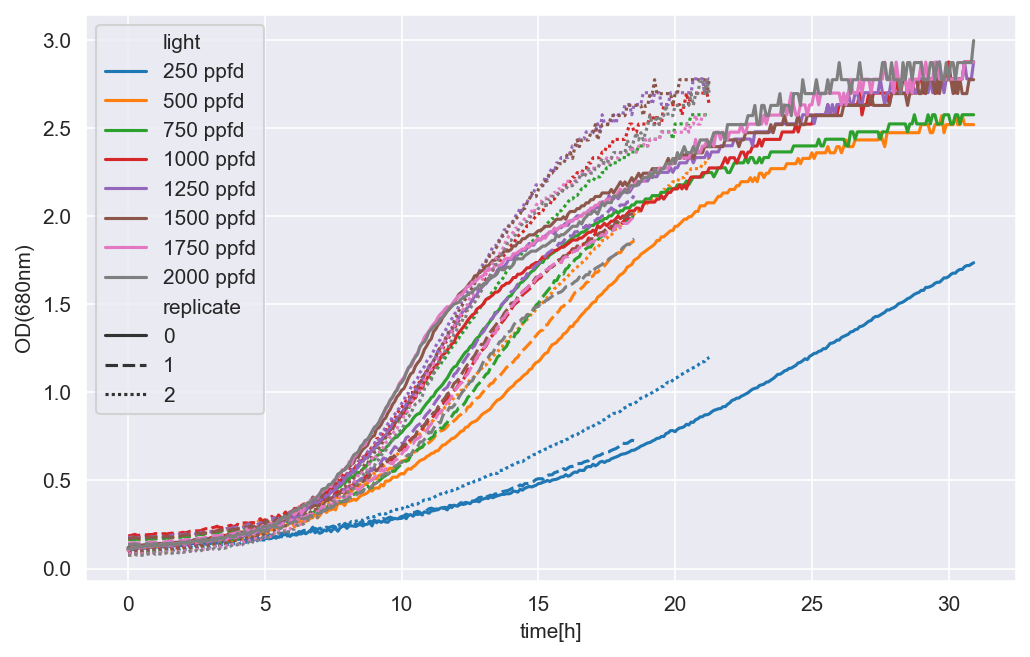

In [179]:
plt.figure(figsize=(8,5), dpi=150)
g = sns.lineplot(x=hourname, y=odname,
             hue=lightname, style="replicate",
             data=df)

AttributeError: 'AxesSubplot' object has no property 'dpi'

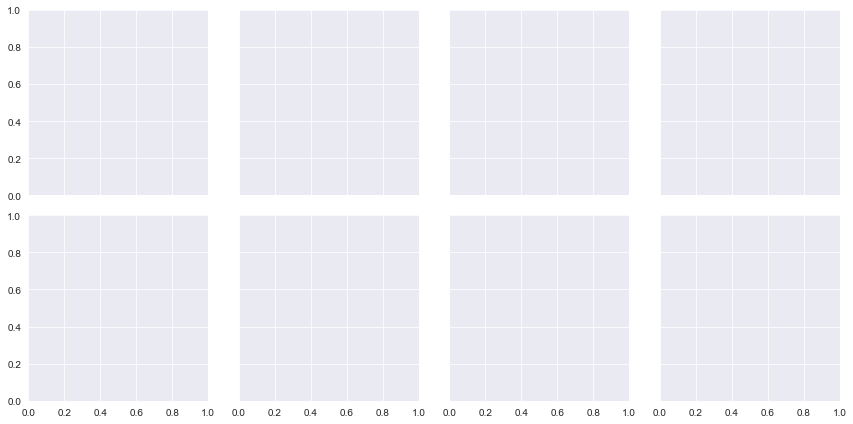

In [221]:
# g = plt.figure(figsize=(12,8), dpi=300)
g = sns.FacetGrid(df, col=lightname, hue="replicate",col_wrap=4)
g.set(dpi=300)
g.map(sns.lineplot, hourname, odname)

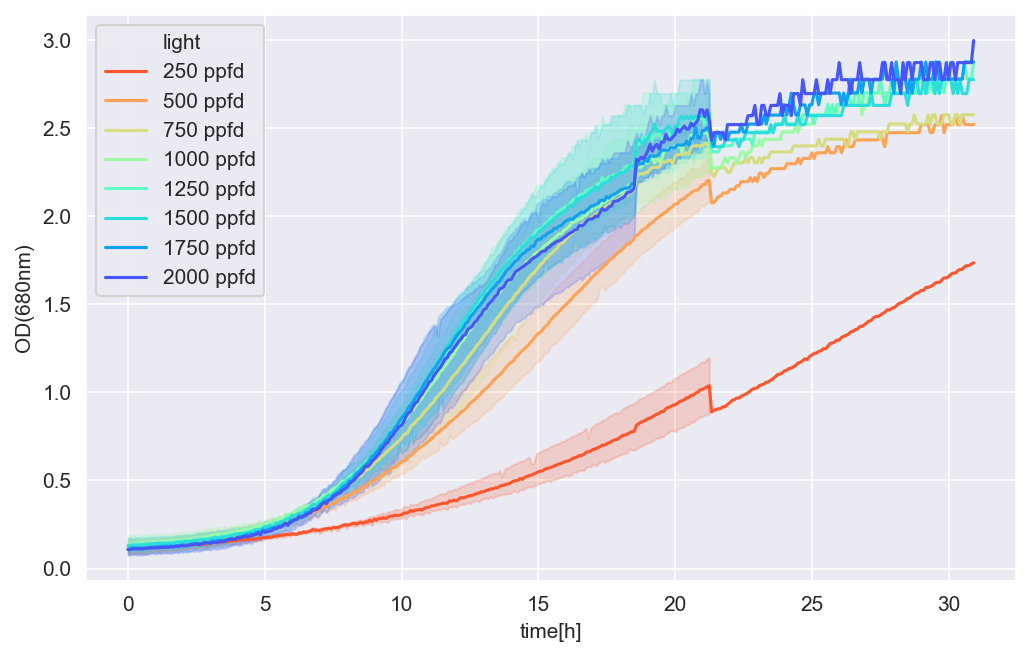

In [191]:
plt.figure(figsize=(8,5), dpi=150)
palette = sns.color_palette("rainbow_r", 8)
sns.lineplot(x=hourname, y=odname,hue=lightname,palette=palette,data=df)